In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,QuantileTransformer,Normalizer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error,make_scorer
from copy import copy
from tpot.builtins import StackingEstimator
import pickle

from src.models.model import mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor,Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from skgarden.quantile import RandomForestQuantileRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
import umap
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')
tgt = ['final.output.recovery','rougher.output.recovery']
year = 2019
X = data_dict[year][f'X_train_tsclean']
print(X.shape)
y = data_dict[year]['y_train']
X_test = data_dict[year]['X_test_ts']
mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
#mask_na_two_row=y[y[tgt].isna()].index.union(y[y[tgt].isna()].index + pd.Timedelta('1 hour')).union(y[y[tgt].isna()].index + pd.Timedelta('2 hour'))
inds = mask.index.difference(exclude_pts.index)

X=X.loc[inds,:]
y=y.loc[inds,:]
mask=mask[inds]
print(X.shape)
print(X_test.shape)

print(f'1) X shape: {X.shape},y: {y.shape}')
X = X[mask]
y = y[mask][tgt]
print(f'2) Train shape: {X.shape}')
X_filt = X.filter(regex  ="rougher|hour|dayw",axis = 1)
train_df = pd.concat([X,y],axis= 1)
train_df.head()


(16859, 763)
(16063, 763)
(5856, 763)
1) X shape: (16063, 763),y: (16063, 7)
2) Train shape: (12838, 763)


,primary_cleaner.input.copper_sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,value__skewness_p120_rougher.input.feed_pb,value__skewness_p120_rougher.input.feed_rate,value__skewness_p120_rougher.input.feed_sol,value__skewness_p120_rougher.input.feed_zn,value__skewness_p120_rougher.input.floatbank10_copper_sulfate,value__skewness_p120_rougher.input.floatbank11_xanthate,value__skewness_p120_rougher.state.floatbank10_b_air,value__skewness_p120_secondary_cleaner.state.floatbank5_a_air,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 01:00:00+00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,-0.621392,-1.503288,-2.032094,-1.105418,-0.861467,-1.440415,-0.190077,-0.074496,69.266198,86.843261
2016-01-15 02:00:00+00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,-0.621392,-1.503288,-2.032094,-1.105418,-0.861467,-1.440415,-0.190077,-0.074496,68.116445,86.842308
2016-01-15 03:00:00+00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,-1.581082,1.219928,1.437744,-1.708960,-1.351549,1.725034,0.664107,-1.403274,68.347543,87.226430
2016-01-15 04:00:00+00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,-0.868829,1.447526,-0.118080,-1.423029,-1.836277,0.001344,1.243404,-0.188030,66.927016,86.688794
2016-01-15 05:00:00+00:00,115.581252,12.470773,7.25,0.965760,1602.964922,-498.090944,1602.074298,-500.179481,1602.154812,-498.642614,...,-1.141334,0.333572,-1.059807,-1.380184,-1.708991,-0.605228,1.521760,0.430250,69.465816,88.156912


## Prepare folding scheme (do i need it ?) and load the pre-trained metafeatures

In [140]:
# Get the K fold indexes
n_folds =6
kf = KFold(n_splits=n_folds, shuffle=False, random_state=156)

with open("../models/test_features_rougher.pkl", "rb") as f:
    test_rougher = pickle.load(f)
with open("../models/train_features_rougher.pkl", "rb") as f:
    train_rougher = pickle.load(f)
with open("../models/test_features_final.pkl", "rb") as f:
    test_final = pickle.load(f)
with open("../models/train_features_final.pkl", "rb") as f:
    train_final = pickle.load(f)



## Define the N features for which to pull the level0 features for; separately for rougher & final

In [155]:
N_final = [50,150,250,350,450]
N_rougher = [50,150,250]
   
# Retrieve rougher predictions:
level0_rougher_train = np.hstack([train_rougher[Nr] for Nr in N_rougher])
level0_final_train = np.hstack([train_final[Nf] for Nf in N_final])

level0_rougher_test = np.hstack([test_rougher[Nr] for Nr in N_rougher])
level0_final_test = np.hstack([test_final[Nf] for Nf in N_final])
tgt = 'rougher.output.recovery'
predictions = level0_rougher_train
yTrue = y[tgt].values
print(f'Shape y : {yTrue.shape}, preds : {predictions.shape}' )

r= mase(level0_rougher_train.mean(axis = 1),y['rougher.output.recovery'].values)
f=mase(level0_final_train.mean(axis = 1),y['final.output.recovery'].values)
print(f'R {r} F {f} sum = {r*0.25+0.75*f}')

Shape y : (12838,), preds : (12838, 18)
R 2.424941718994315 F 1.5194040355719265 sum = 1.7457884564275237


In [160]:
#predictions.mean(axis = 1)*r+

(12838, 24)

## Run an optimization with constraints on positive weights

In [174]:
from scipy.optimize import minimize

def f(weights):
    valid_preds_r = np.average(predictions_r, axis=1, weights=weights).reshape((-1,1))
    valid_preds_f = np.average(predictions_f, axis=1, weights=weights).reshape((-1,1))

    return np.hstack([valid_preds_r,valid_preds_f])

def loss_function(weights,C = 0.7):
    y_valid_pred = f(weights)
    sc = 0.25*mase(y_valid_pred[:,0],y['rougher.output.recovery'].values) + 0.75*mase(y_valid_pred[:,1],y['final.output.recovery'].values) + C*(weights**2).sum()
    #print('loss', sc, 'current weights', weights)
    return sc

opt_weights = minimize(loss_function,
                                [1/predictions_r.shape[1]] * predictions_r.shape[1],
                                constraints=({'type': 'eq','fun': lambda w: 1-sum(w)}),
                                method= 'SLSQP',
                                bounds=[(0.0, 1.0)] * predictions_r.shape[1],
                                options = {'ftol':1e-10},
                            )['x']

print('Optimum weights = ', opt_weights, 'with loss', loss_function(opt_weights))

def acc_function(weights):
    y_valid_pred = f(weights)
    sc = 0.25*mase(y_valid_pred[:,0],y['rougher.output.recovery'].values) + 0.75*mase(y_valid_pred[:,1],y['final.output.recovery'].values)
    return sc

print('Ensembled Accuracy =', acc_function(opt_weights))

# 0.00000000e+00 1.53911667e-15 4.63643997e-02 0.00000000e+00
# 7.57377707e-02 8.77897830e-01]

Optimum weights =  [0.09214325 0.08326996 0.07945414 0.0990743  0.08116201 0.06146224
 0.03220819 0.03520512 0.04069526 0.02343084 0.03200855 0.02826872
 0.0393319  0.0419227  0.03373259 0.03186965 0.04191969 0.03413302
 0.01055219 0.0226742  0.010269   0.01671587 0.01688005 0.01161656] with loss 1.7586020102753923
Ensembled Accuracy = 1.7179782225732336


0.041666666666666664

## Make a submission:

In [177]:
preds = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level0_rougher_test.dot(opt_weights), 'final.output.recovery':level0_final_test.dot(opt_weights)})
stacked_preds_sub = preds
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
#stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_r_350_f450_C07_weighted.csv')

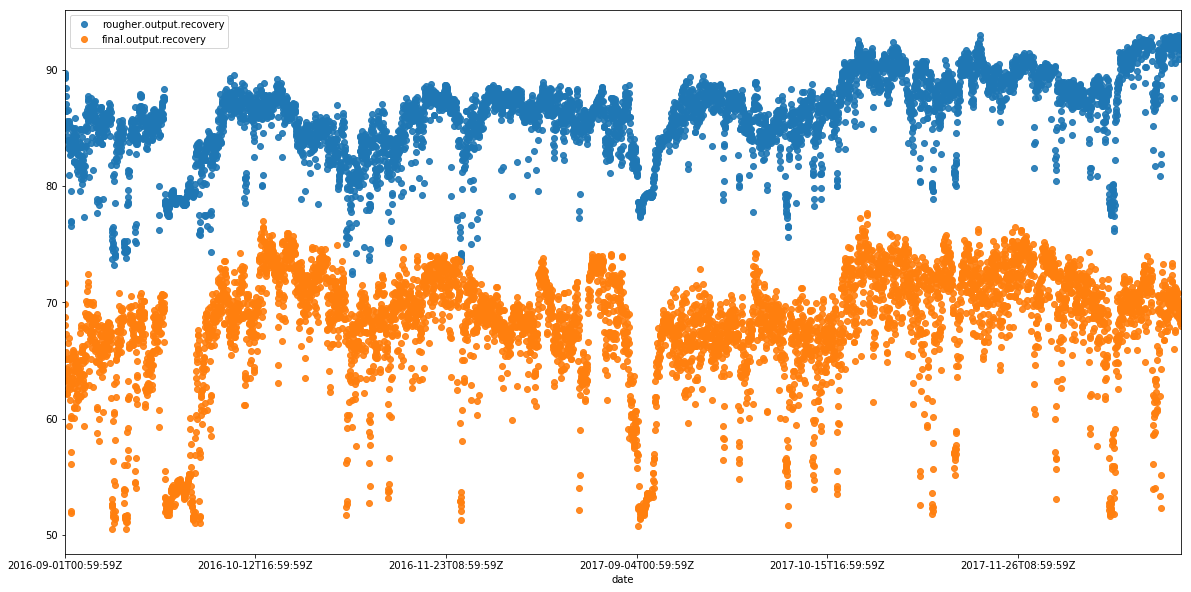

In [178]:
stacked_preds_sub.plot(style=['o','o'],figsize = (20,10),alpha=0.9)


In [ ]:
preds_av = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level0_testFeatures_rougher.mean(axis=1), 'final.output.recovery':level0_testFeatures_final.mean(axis=1)})

preds_av['date'] = preds_av['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
preds_av.set_index('date',inplace=True)
preds_av.plot(figsize = (20,10),style=['o','o'],alpha=0.9)

preds_av.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_lagdiff5_ts_averaged.csv')

In [ ]:
r = np.power(level0_testFeatures_rougher.prod(axis=1),1/level0_testFeatures_rougher.shape[1])
f = np.power(level0_testFeatures_final.prod(axis=1),1/level0_testFeatures_final.shape[1])

preds_av = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':r, 'final.output.recovery':f})
preds_av['date'] = preds_av['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
preds_av.set_index('date',inplace=True)
preds_av.plot(figsize = (20,10),style=['o','o'],alpha=0.9)